In [1]:
from casadi import *
import numpy as np

In [2]:
T = 5. # Time horizon
N = 100 # number of control intervals
tau_theta = 10*np.random.uniform()
tau_phi = 10*np.random.uniform()
lam = 100
init1 = np.pi/20*np.random.normal()
init2 = np.pi/20*np.random.normal()

# Declare model variables
x1 = MX.sym('x1')
x2 = MX.sym('x2')
x = vertcat(x1, x2)
u = MX.sym('u')

# Model equations
xdot = vertcat(-x1/tau_theta, -u*x2+x1/tau_phi)

# Objective term
L = (x1+x1)**2+lam*u**2

In [3]:
# Formulate discrete time dynamics
if False:
    # CVODES from the SUNDIALS suite
    dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
    opts = {'tf':T/N}
    F = integrator('F', 'cvodes', dae, opts)
else:
    # Fixed step Runge-Kutta 4 integrator
    M = 4 # RK4 steps per interval
    DT = T/N/M
    f = Function('f', [x, u], [xdot, L])
    X0 = MX.sym('X0', 2)
    U = MX.sym('U')
    X = X0
    Q = 0
    for j in range(M):
        k1, k1_q = f(X, U)
        k2, k2_q = f(X + DT/2 * k1, U)
        k3, k3_q = f(X + DT/2 * k2, U)
        k4, k4_q = f(X + DT * k3, U)
        X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
        Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
    F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])

In [4]:
# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g = []
lbg = []
ubg = []

# Formulate the NLP
Xk = MX([init1, init2])
for k in range(N):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k))
    w += [Uk]
    lbw += [-2*np.pi]
    ubw += [2*np.pi]
    w0 += [0]

    # Integrate till the end of the interval
    Fk = F(x0=Xk, p=Uk)
    Xk = Fk['xf']
    J=J+Fk['qf']

    # Add inequality constraint
    g += [Xk[0]]
    lbg += [-2*np.pi]
    ubg += [2*np.pi]

In [15]:
# Create an NLP solver
prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
# w_opt = sol['x']

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      100
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

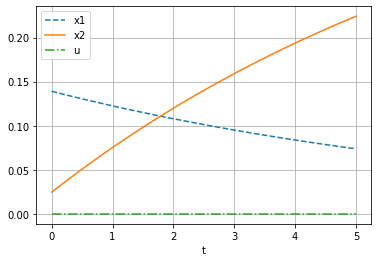

In [104]:
# Plot the solution
u_opt = w_opt
x_opt = [[init1, init2]]
for k in range(N):
    Fk = F(x0=x_opt[-1], p=u_opt[k])
    x_opt += [Fk['xf'].full()]
x1_opt = [r[0] for r in x_opt]
x2_opt = [r[1] for r in x_opt]

tgrid = [T/N*k for k in range(N+1)]
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, x1_opt, '--')
plt.plot(tgrid, x2_opt, '-')
plt.step(tgrid, vertcat(DM.nan(1), u_opt), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()